<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
%pip install statsmodels --upgrade
%pip install pandas --upgrade
%pip install lightgbm


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



In [3]:
warnings.simplefilter(action='ignore')
%matplotlib inline

In [4]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'
    
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Преобразуем даты и время в формат `datetime` и перенесем в индекс

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
df.set_index('datetime', inplace=True)

In [10]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверим на монотонность

In [11]:
df.index.is_monotonic

True

Произведем ресемплирование с интервалом 1 час

In [12]:
df_hour = df.resample('1H').sum()

## Анализ

Подготовим функцию для визуального анализа датасета и функцию для декомпозиции временного ряда на сезонную составляющую, тренд и остаток

In [13]:
def df_analize(df, rolling_size=10):

    print(df['num_orders'].describe())

    plt.figure(figsize=(15,15))

    plt.subplot(3,1,1)
    sns.lineplot(data=df, x=df.index, y='num_orders', label='num_orders')
    sns.lineplot(data=df, x=df.index, y=df['num_orders'].rolling(rolling_size).mean(), label='mean')
    sns.lineplot(data=df, x=df.index, y=df['num_orders'].rolling(rolling_size).std(), label='std')
    plt.grid(True)
    plt.legend()

    plt.subplot(3,1,2)
    sns.histplot(df, x='num_orders', kde=True)
    plt.grid(True)

    plt.subplot(3,1,3)
    sns.boxplot(data=df, x='num_orders')
    plt.grid(True)
    plt.show()

In [14]:
def df_decompose(df, day_name=False):    
    decomposed = seasonal_decompose(df)
    plt.figure(figsize=(15,25))
    plt.subplot(3,1,1)
    if day_name:
        sns.lineplot(data=decomposed.trend, x=decomposed.trend.index.strftime('%d %A'), y=decomposed.trend)
    else:
        sns.lineplot(data=decomposed.trend, x=decomposed.trend.index, y=decomposed.trend)
    plt.grid()
    plt.xticks(rotation=25)
    plt.title('Тренд')
    plt.subplot(3,1,2)
    if day_name:
        sns.lineplot(data=decomposed.seasonal, x=decomposed.trend.index.strftime('%d %A'), y=decomposed.seasonal)
    else:
        sns.lineplot(data=decomposed.seasonal, x=decomposed.trend.index, y=decomposed.seasonal)
    plt.grid()
    plt.xticks(rotation=25)
    plt.title('Сезонность')
    plt.subplot(3,1,3)
    if day_name:
        sns.lineplot(data=decomposed.resid, x=decomposed.trend.index.strftime('%d %A'), y=decomposed.resid)
    else:
        sns.lineplot(data=decomposed.resid, x=decomposed.trend.index, y=decomposed.resid)
    plt.grid()
    plt.xticks(rotation=25)
    plt.title('Остаток')
    plt.show()

Проанализируем данные с интервалом в 1 час

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


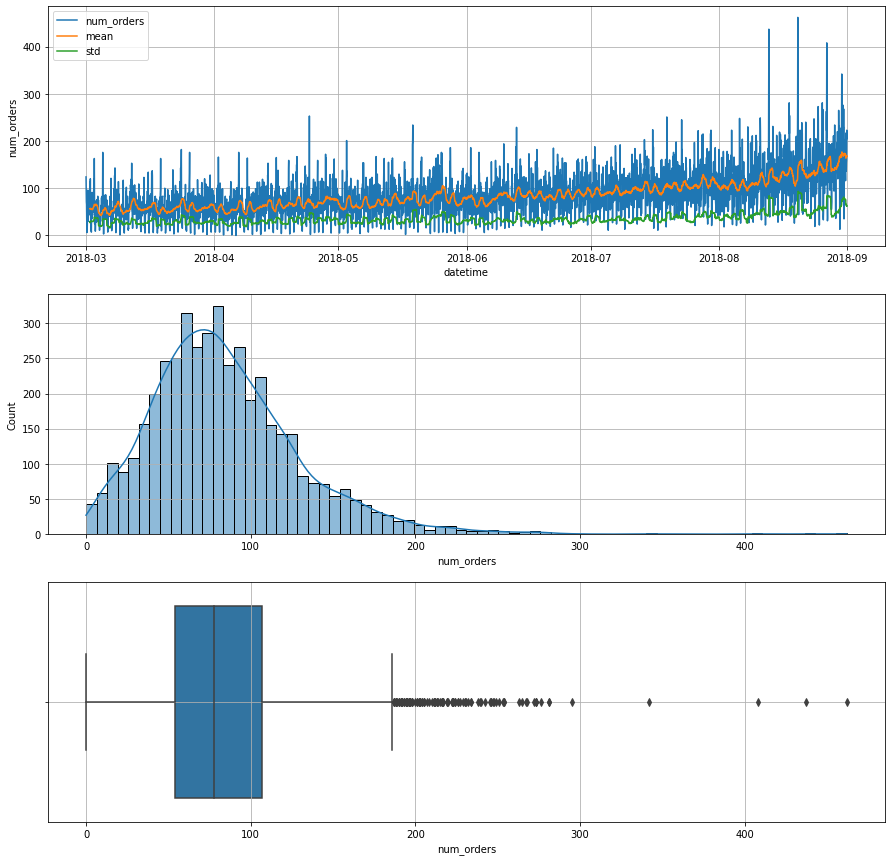

In [15]:
df_analize(df_hour, rolling_size=24)

Среднее значение и стандартное отклонение количества заказов такси увеличивается со временем (ряд не стационарен).
Среднее количесвто заказов в час составило за рассматриваемый промежуток 84 заказа. Свыше 300-х заказов в час было всего несколько раз, однако все они приурочены к последнему месяцу и не являются ошибочными значениями.

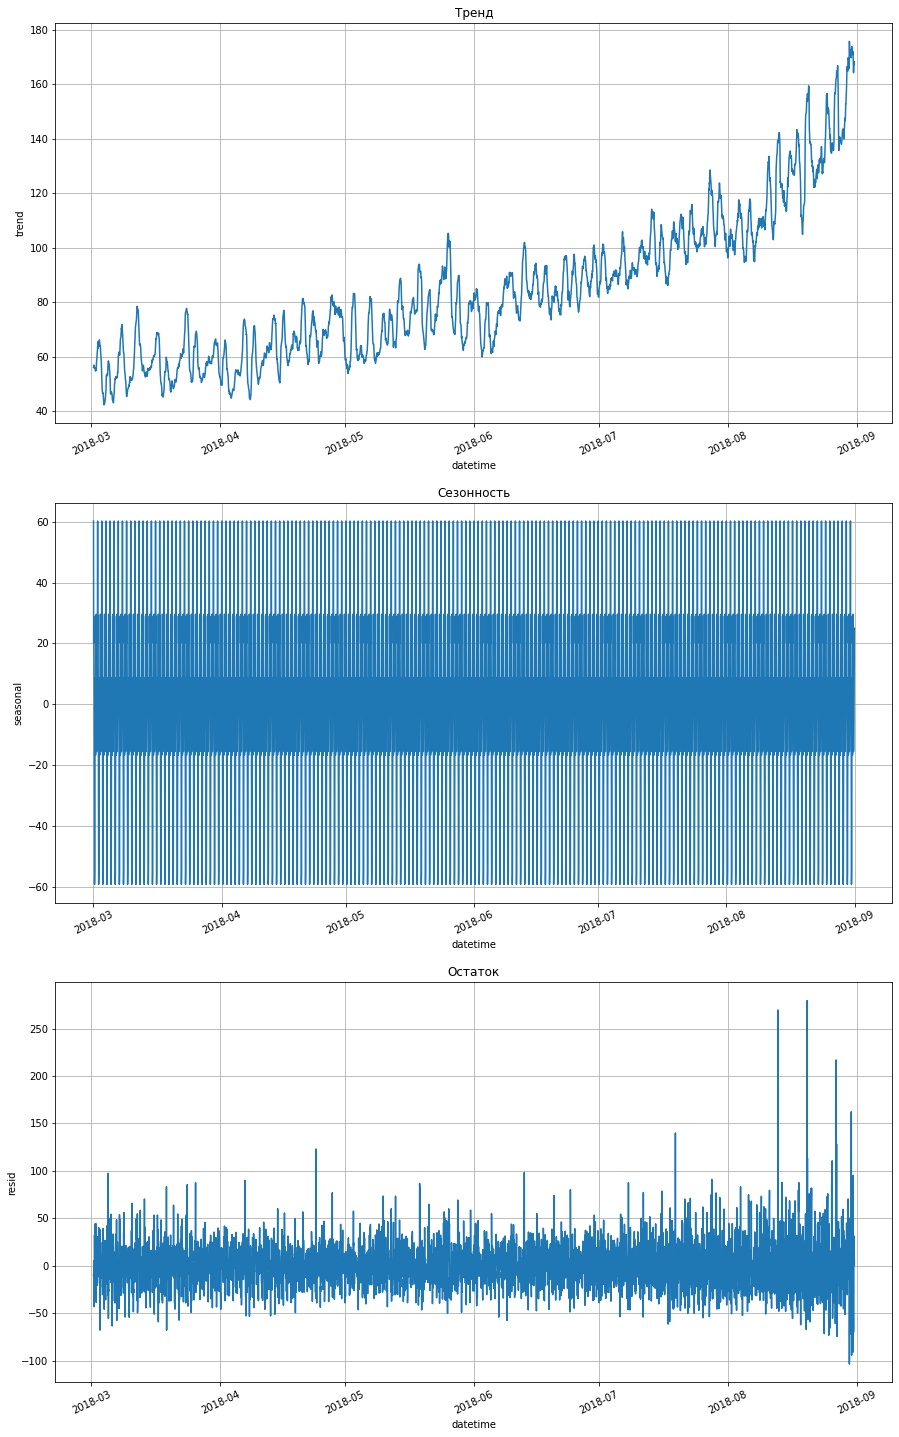

In [16]:
df_decompose(df_hour)

Возрастающий тренд прослеживается четко, однако в таком масштабе трудно судить о сезонной составляющей. Расмотрим срез данных за несколько последних дней

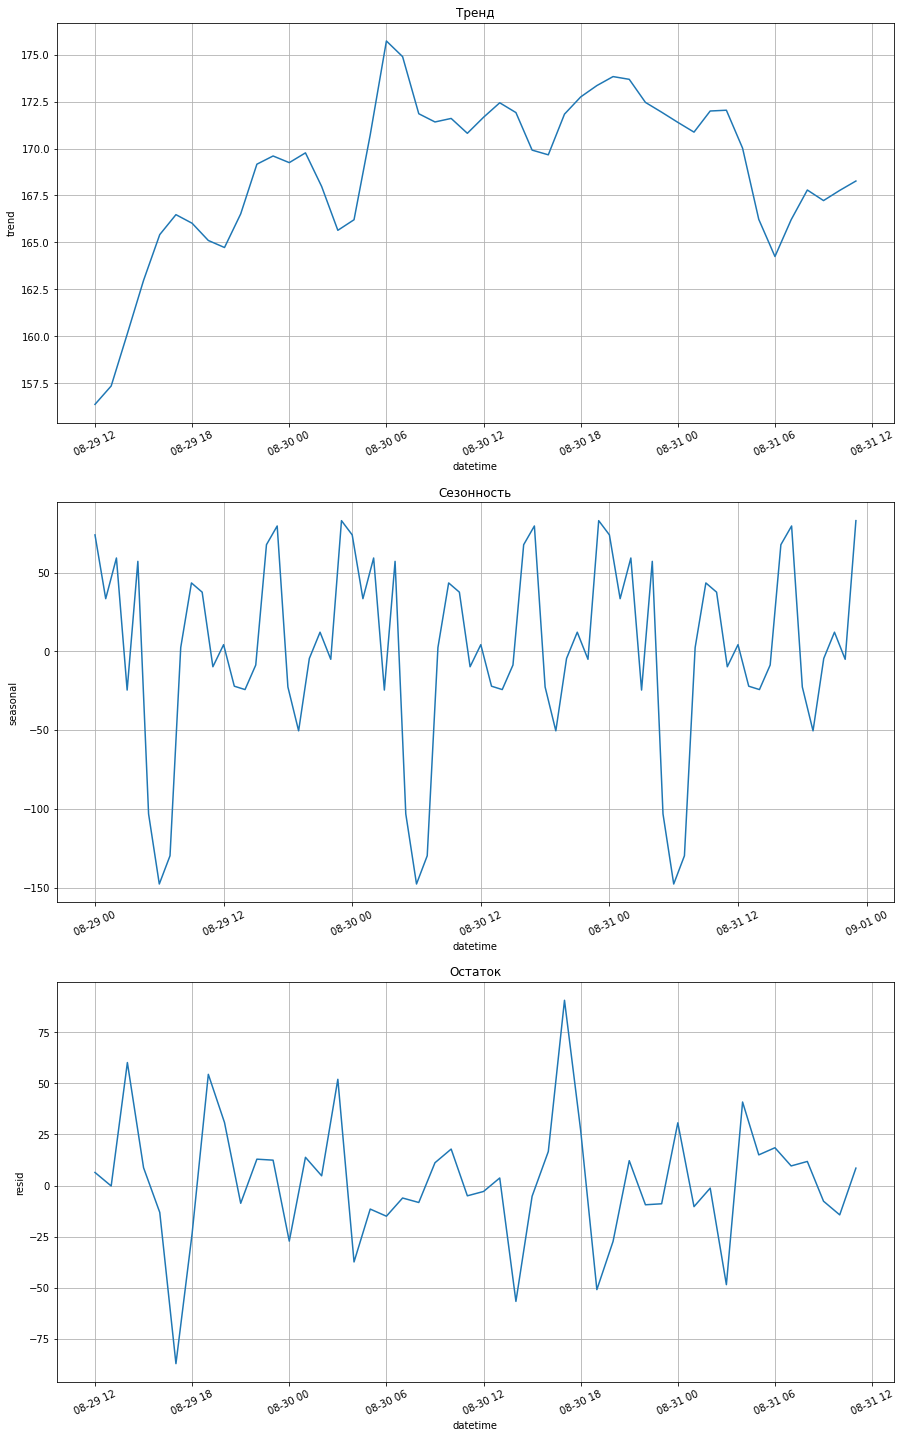

In [17]:
df_decompose(df_hour['2018-08-29':'2018-08-31'])

Количество заказов резко падает с 12 ночи до 6 утра, возрастает в утренние часы, достигая утреннего пика в районе 9-10 часов. Далее идет некоторое снижение до 14 часов, с последующим ростом до максимальных значений в районе 17-18 часов. Дальше количество заказов опять снижается до 20 часов и начинает расти в вечерние часы, достигая пика в районе 23-24 часов ночи.

Рассмотрим также количество заказов, просуммированные за каждый день.

In [18]:
df_day = df.resample('1D').sum()

count     184.000000
mean     2026.146739
std       635.874120
min      1076.000000
25%      1547.500000
50%      1911.500000
75%      2349.750000
max      4090.000000
Name: num_orders, dtype: float64


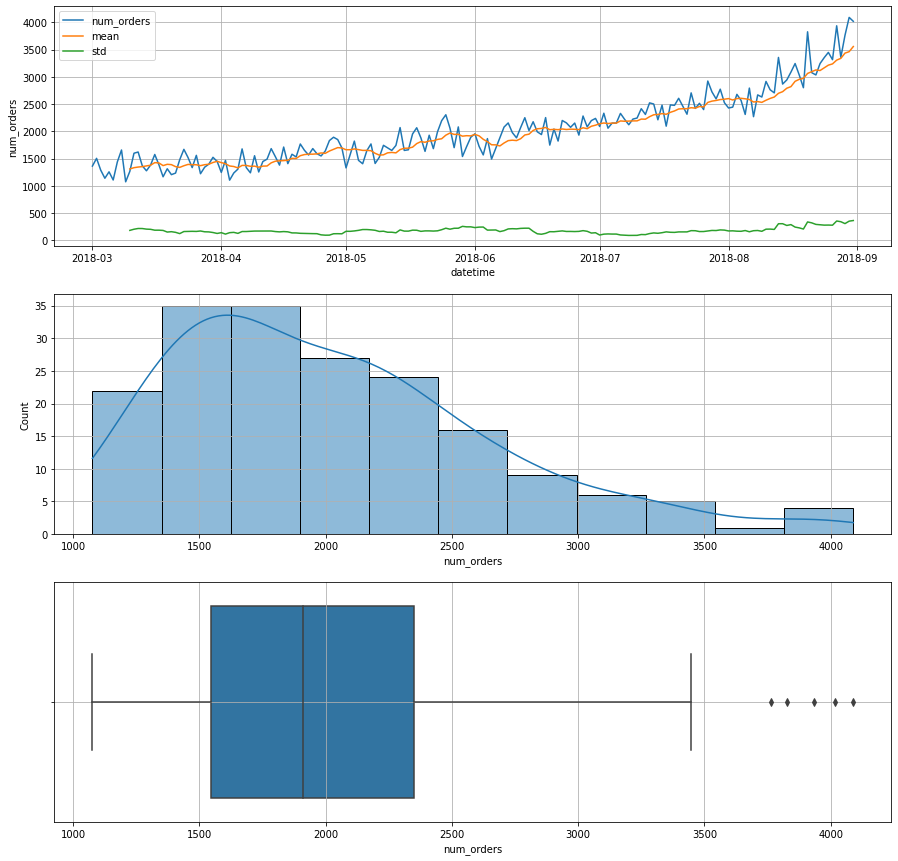

In [19]:
df_analize(df_day)

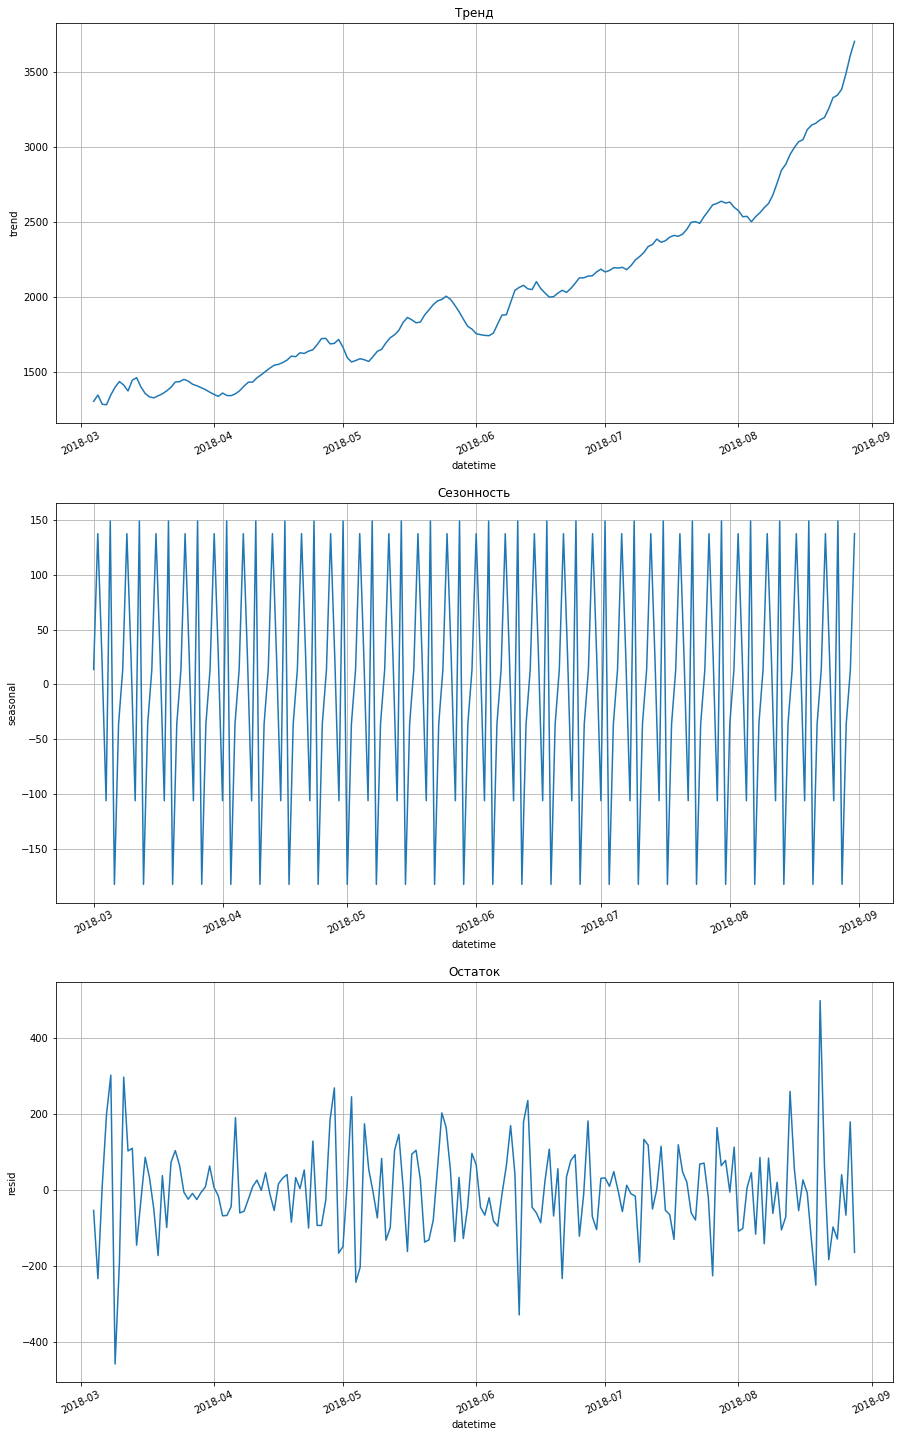

In [20]:
df_decompose(df_day)

Рассмотри данные за несколько последних недель, по временной оси выведем название дня недели

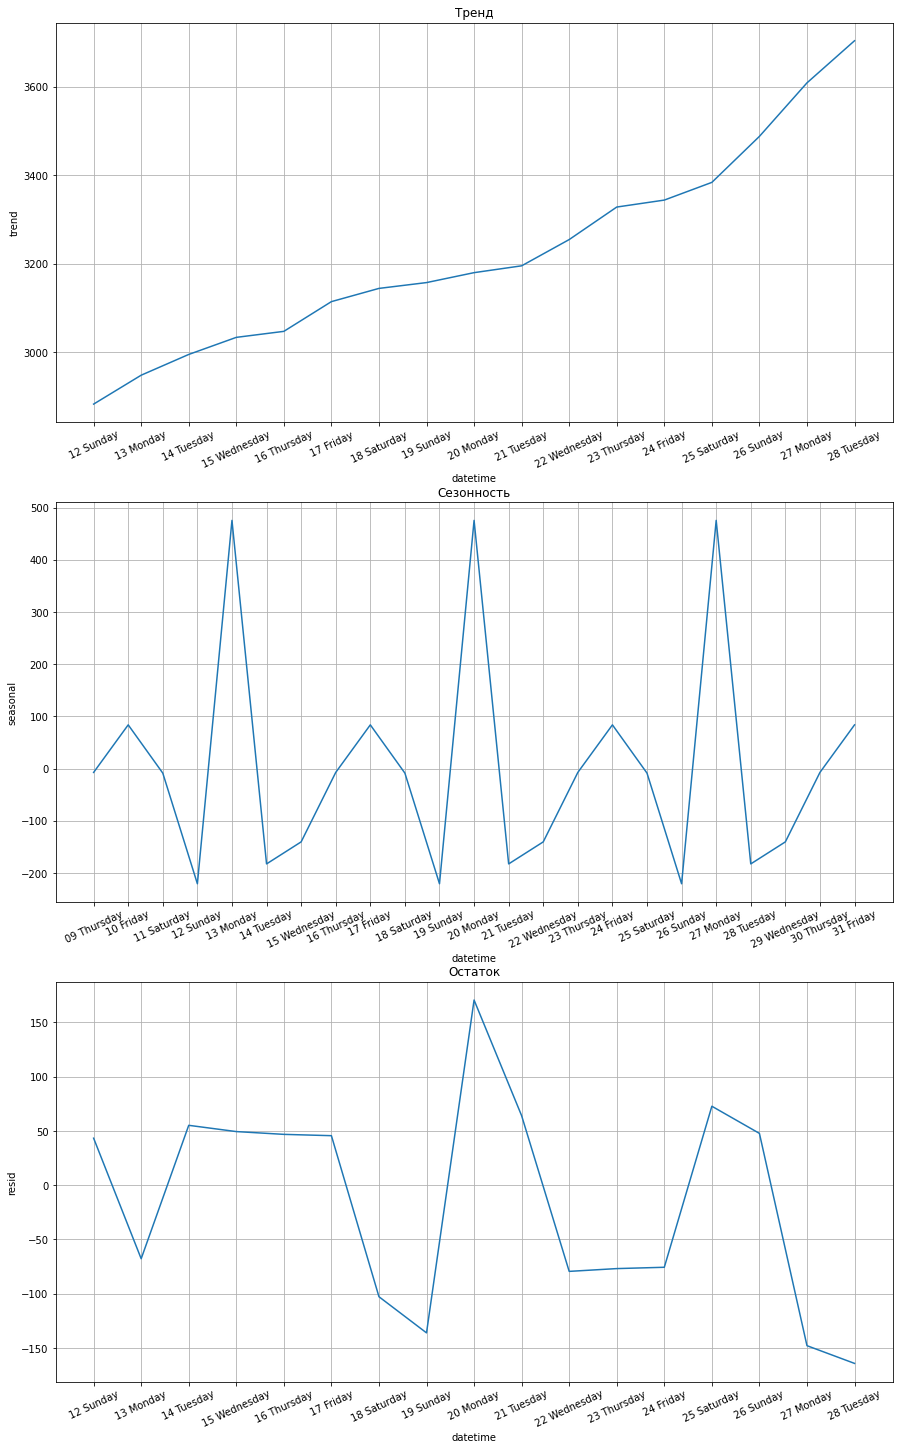

In [21]:
df_decompose(df_day['2018-08-09':'2018-08-31'], day_name=True)

Сезонность по дням недели также прослеживается: минимальное значение в воскресенье, максимальное значение в понедельник, во вторник наблюдается минимальное значение в течение рабочей недели, в остальные дни до пятницы включительно идет рост количества заказов и снижается в выходные дни.

## Обучение

Создадим признаки час, день недели, месяц, отстающие значения и скользящее среднее

In [22]:
def make_features(df, max_lag=10, rolling_window_size=10):
    df_with_features = df.copy()
    df_with_features['dayofweek'] = df_with_features.index.dayofweek
    df_with_features['hour'] = df_with_features.index.hour
    df_with_features['month'] = df_with_features.index.month
    
    for lag in range(1, max_lag + 1):
        df_with_features['lag_{}'.format(lag)] = df_with_features['num_orders'].shift(lag)
    
    df_with_features['rolling_mean'] = df_with_features['num_orders'].shift().rolling(rolling_window_size).mean()
    df_with_features.dropna(inplace=True)

    return df_with_features

In [23]:
df_model = make_features(df_hour)

In [24]:
df_model.head()

,num_orders,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


In [25]:
X = df_model.drop('num_orders', axis=1)
y = df_model['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)


In [26]:
X_train.shape[0] / X_test.shape[0]

8.99092970521542

Проверим правильность расположения временных рядов, чтобы начало тестовой выборки следовал за окончанием обучающей

In [27]:
display(X_train.tail(2))
X_test.head(2)

,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 13:00:00,0,13,8,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,111.9
2018-08-13 14:00:00,0,14,8,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0


,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 15:00:00,0,15,8,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9
2018-08-13 16:00:00,0,16,8,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,112.1


In [28]:
tscv = TimeSeriesSplit(n_splits=3)

Определим функцию для расчета rmse на кросс-валидации 

In [29]:
def rmse_cv(estimator, X=X_train, y=y_train):
    rmse  = (cross_val_score(estimator=estimator, 
                                X=X, 
                                y=y, 
                                cv=tscv,
                                n_jobs=-1, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

    return rmse

Также определим функцию для расчета rmse на кросс-валидации с перебором гиперпараметров

In [30]:
def rmse_gscv(estimator, param_grid, X=X_train, y=y_train):
    gsearch = GridSearchCV(estimator=estimator, 
                        param_grid = param_grid, 
                        cv=tscv,
                        n_jobs = -1,
                        scoring='neg_mean_squared_error')
    gsearch.fit(X, y)
    gsearch_best_score = (gsearch.best_score_*-1) ** 0.5
    print ('RMSE:', gsearch_best_score)
    return gsearch

Построим первую модель на значениях max_lag и rolling_window_size, равных 10.

In [31]:
lr = LinearRegression()
rmse_cv(lr)

32.8994752182537

Проверим возможность улучшения модели за счет варьирования значений max_lag и rolling_window_size.

In [32]:
list_lag=[]
list_rws=[]
list_rmse=[]
for lag in range(1, 51):
    for rws in range(1, 26):
        df_search = make_features(df_hour, max_lag=lag, rolling_window_size=rws)
        X_full = df_search.drop('num_orders', axis=1)
        y_full = df_search['num_orders']
        X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_full, y_full, shuffle=False, test_size=0.1)
        estimator=LinearRegression()
        rmse_search = rmse_cv(estimator, X=X_temp_train, y=y_temp_train)
        list_lag.append(lag)
        list_rws.append(rws)
        list_rmse.append(rmse_search)
        

<AxesSubplot:xlabel='rws', ylabel='lag'>

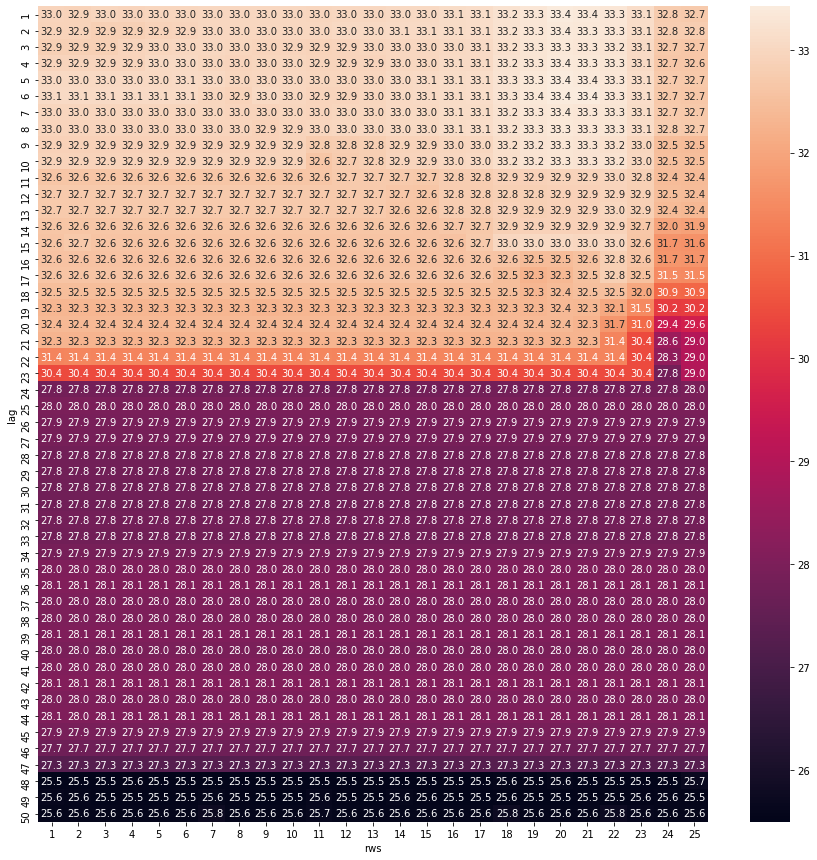

In [33]:
plt.figure(figsize=(15,15))
(sns.heatmap(pd.DataFrame({'lag':list_lag, 'rws':list_rws, 'rmse':list_rmse}).
    pivot_table(index='lag', columns='rws', values='rmse'), annot=True, fmt='0.1f'))

Качество модели возрастает до  достижения max_lag значения 48ч. Интересной особенностью является то, что качество модели скачкообразно возрастает при достижении max_lag значения 24 и 48 часов, вероятно, модель отлавливает закономерности суточных изменений.  
При небольших значениях max_lag, качество модели несколько возрастает при достижении значения rolling_window_size 24ч. Когда размер  max_lag больше 24 часа, качество модели практически не зависит от размера скользящего окна.  
Для построения признаков определим max_lag равным 48ч, а размер окна, для скользящего среднего оставим по умолчанию равным 10.

In [34]:
df_opt = make_features(df_hour, max_lag=48, rolling_window_size=10)
X_opt = df_opt.drop('num_orders', axis=1)
y_opt = df_opt['num_orders']
X_opt_train, X_opt_test, y_opt_train, y_opt_test = train_test_split(X_opt, y_opt, shuffle=False, test_size=0.1)

In [35]:
lr=LinearRegression()
rmse_lr = rmse_cv(lr, X=X_opt_train, y=y_opt_train)
rmse_lr

25.50552414186786

Посмотрим какие признаки оказали наибольший вклад в модель Линейной Регрессии, для этого потроим аналогичную модель на масштабированных значениях предикторов и сравним коэффициенты уравнения регрессии.

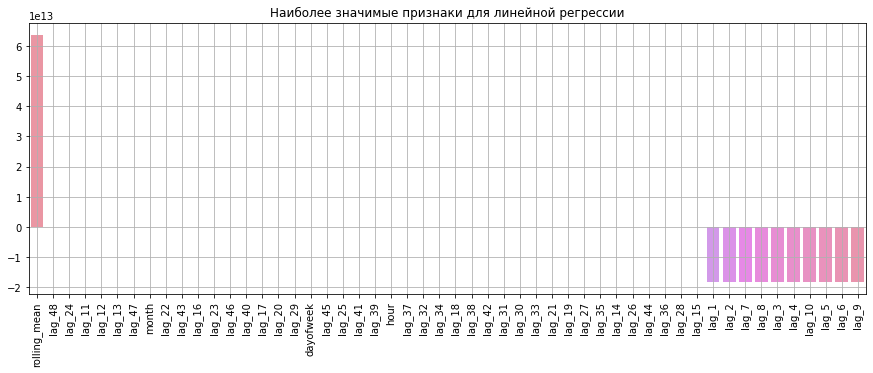

In [36]:
scaler = MinMaxScaler()
X_scal_train = pd.DataFrame(scaler.fit_transform(X_opt_train), columns=X_opt_train.columns, index=X_opt_train.index)
lr_scal = LinearRegression()
feat_importances = pd.Series(lr_scal.fit(X_scal_train, y_opt_train).coef_, 
                                index=X_scal_train.columns).sort_values(ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(x=feat_importances.index, y=feat_importances.values)
plt.grid()
plt.title('Наиболее значимые признаки для линейной регрессии')
plt.xticks(rotation=90);

Наибольший вклад внесли скользящее среднее и несколько значений отстающих признаков.

Исследуем модель Случайного Леса с параметрами по умолчанию и с перебором некоторых гиперпараметров

In [37]:
rfr_default = rmse_cv(RandomForestRegressor(random_state=555),
                        X=X_opt_train, 
                        y=y_opt_train)
rfr_default

25.929432973578436

In [38]:
rfr_grid = {'n_estimators'  :   list(range(50, 251, 25)),
            'max_depth'     :   list(range(10, 31, 5))}
rfr = rmse_gscv(RandomForestRegressor(random_state=555), 
                param_grid=rfr_grid, 
                X=X_opt_train, 
                y=y_opt_train)

RMSE: 25.728720194028607


In [39]:
rfr.best_params_

{'max_depth': 25, 'n_estimators': 175}

Качество модели Случайного Леса на кросс-валидации оказалось на уровне моделей Линейной Регрессии, перебор гиперпараметров несколько повысил качество, но не существенно. Обучение дефолтной модели потребовало несколько больше времени, чем модель Линейной Регрессии

Определим функцию для построения диаграммы важности признаков исходя из атрибута модели `feature_importances_`

In [40]:
def feature_importances_chart(model, X, model_name):
    feat_importances = pd.Series(model.feature_importances_, 
                                index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(15,5))                                        
    sns.barplot(x=feat_importances.index, y=feat_importances.values)
    plt.grid()
    plt.title(f'Наиболее значимые признаки для модели {model_name}')
    plt.xticks(rotation=90);

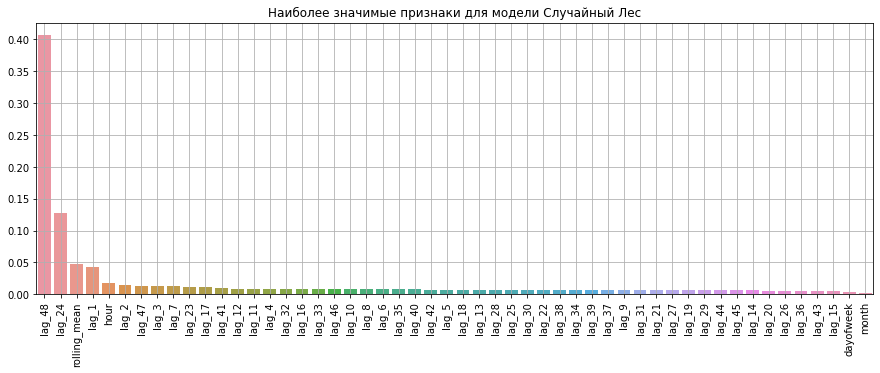

In [41]:
feature_importances_chart(rfr.best_estimator_, X=X_opt_train, model_name="Случайный Лес")

Для модели Случайного Леса наиболее выжными признаками оказались отстающее на 48ч и на 24ч количество заказов. Достаточно важными признаками также являются среднее скользящее и количество заказов за предыдущий час.  

Исследуем модель Градиентного Бустинга в реализации библиотеки LightGBM

In [42]:
lgbr_default = rmse_cv(LGBMRegressor(random_state=555),
                        X=X_opt_train, 
                        y=y_opt_train)
lgbr_default

25.23536289715648

In [43]:
lgbmr_grid = {'max_depth'           : list(range(4, 16, 4)),
            'n_estimators'          : list(range(100, 401, 100)),
            'learning_rate'         : [0.25, 0.05, 0.75, 0.01]}

lgbmr = rmse_gscv(LGBMRegressor(random_state=555), 
                param_grid=lgbmr_grid, 
                X=X_opt_train, 
                y=y_opt_train)  

RMSE: 25.063340826605508


In [44]:
lgbmr.best_params_

{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300}

Градиентный Бустиг на кросс-валидации по обучающей выборке показал несколько лучшее значение метрики качества rmse по сравнению с Линейной Регрессией и Случайным Лесом. Рассмотренный набора гиперпараметров из глубины деревьев, количества итерации и скорости обучения позволил незначительно нарастить качество модели.

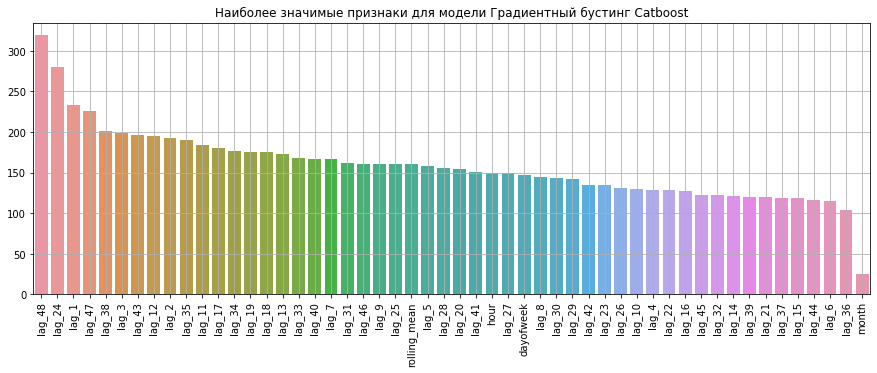

In [45]:
feature_importances_chart(lgbmr.best_estimator_, X=X_opt_train, model_name="Градиентный бустинг Catboost")

Важные признаки для модели Градиентного Бустинга во многом схожи с моделью Случайного Леса, за исключением важности скользящей средней.

## Тестирование

Для исследованных моделей произведем обучение на всем наборе обучающих данных, для модели Случайного Леса b Градиентного Бустинга используем  подобранные гиперппараметры. Замерим длительность обучения, а также качество предсказания на тестовых данных. Подготовим соответсвующую функцию.

In [46]:
def model_result(model, X_train, X_test, y_train, y_test):
    '''
    Функция обучает модель на обучающем наборе данных,
    возвращает метрику качества rmse на тестовом наборе данных, время обучения и предсказания
    '''
    start1 = time.time()
    model.fit(X_train, y_train)
    end1 = time.time()
    time_train = end1 - start1

    start2 = time.time()
    y_pred = model.predict(X_test)
    end2 = time.time()
    time_predict = end2 - start2

    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    return round(rmse), round(time_train, 2), round(time_predict, 2)

In [47]:
# LinearRegressor
lr_result = model_result(model=LinearRegression(), 
                                X_train=X_opt_train, 
                                X_test=X_opt_test,
                                y_train=y_opt_train,
                                y_test=y_opt_test)
lr_result

(43, 0.0, 0.01)

In [48]:
# RandomForestRegressor
rfr_result = model_result(model=RandomForestRegressor(random_state=555, **rfr.best_params_), 
                                X_train=X_opt_train, 
                                X_test=X_opt_test,
                                y_train=y_opt_train,
                                y_test=y_opt_test)
rfr_result

(40, 14.37, 0.03)

In [49]:
# LightGBMRegressor 
lgbmr_result = model_result(model=LGBMRegressor(random_state=555, **lgbmr.best_params_), 
                                X_train=X_opt_train, 
                                X_test=X_opt_test,
                                y_train=y_opt_train,
                                y_test=y_opt_test)
lgbmr_result

(39, 0.46, 0.01)

In [50]:
model_list = [lr_result, rfr_result, lgbmr_result]
rmse_list = [model[0] for model in model_list]
time_train_list = [model[1] for model in model_list]
time_predict_list = [model[2] for model in model_list]
model_name_list = ['LinearRegresson', 'RandomForestRegressor', 'LightGBMRegressor']

In [51]:
results_df = pd.DataFrame(data={'RMSE':rmse_list, 'Time_train':time_train_list, 'Time_predict':time_predict_list,},
                                                                                index=model_name_list)
results_df

,RMSE,Time_train,Time_predict
LinearRegresson,43,0.00,0.01
RandomForestRegressor,40,14.37,0.03
LightGBMRegressor,39,0.46,0.01


Значение метрики RMSE на тестовой выборке составляет для рассмотренных моделей от 39 до 43ч, что соответствует требованиям проекта по качеству моделей. Лучшее значение метрики, а также сравнительно низкое время обучения получено на модели Градиентного Бустинга, данную модель можно рекомендовать для прогноза количества заказов.

Построим графики фактических и прогнозных значений количества заказов такси

In [52]:
def visual_comparison(model, X=X_opt_test, y=y_opt_test, x_lim_left=None, x_lim_right=None):
    plt.figure(figsize=(15, 7))
    sns.lineplot(x = y.index, y = y, label='Факт')
    sns.lineplot(x = y.index, y = model.predict(X), label='Прогноз')
    plt.xticks(rotation=25)
    plt.xlim(pd.to_datetime(x_lim_left),pd.to_datetime(x_lim_right))
    plt.grid()
    plt.title('Сравнение фактических и прогнозных значений на тестовой выборке')

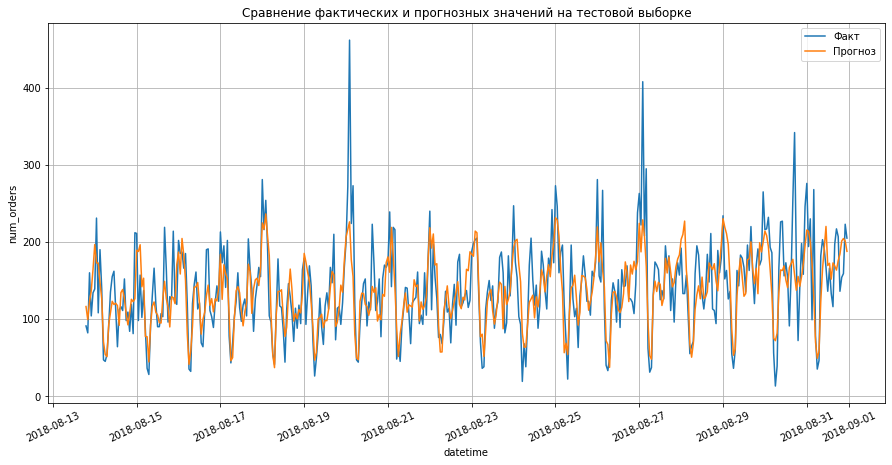

In [53]:
visual_comparison(model=lgbmr.best_estimator_)

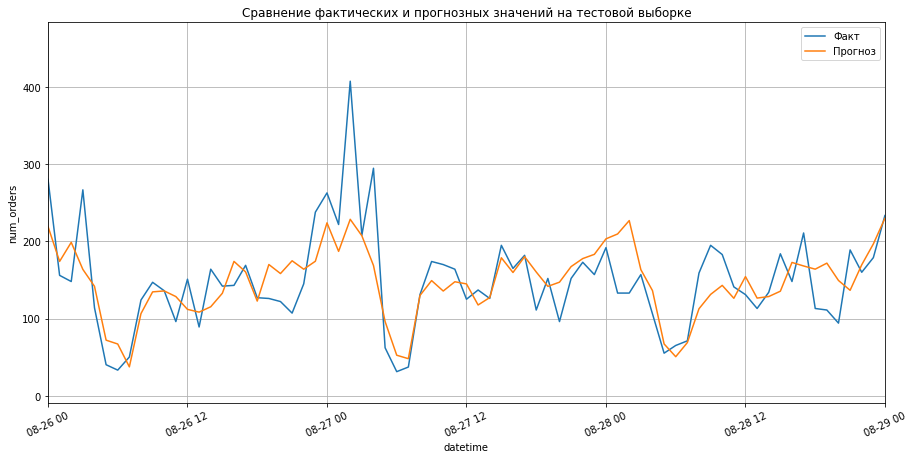

In [54]:
visual_comparison(model=lgbmr.best_estimator_, x_lim_left='2018-08-26', x_lim_right='2018-08-29')

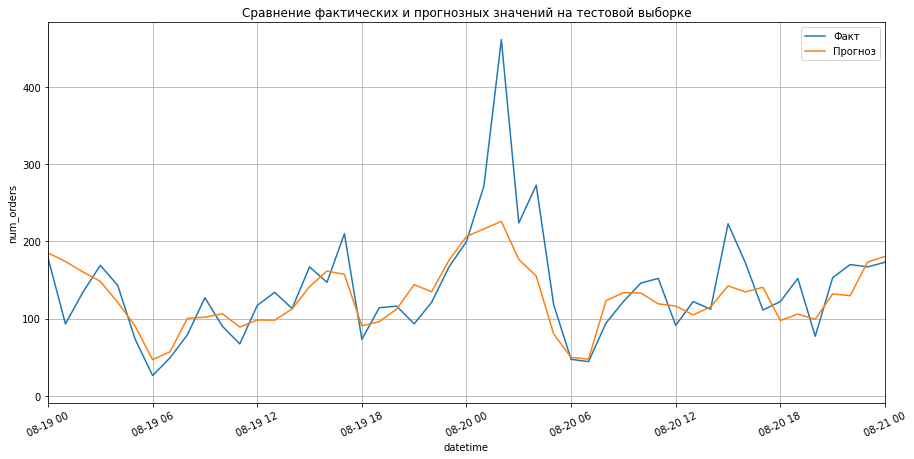

In [55]:
visual_comparison(model=lgbmr.best_estimator_, x_lim_left='2018-08-19', x_lim_right='2018-08-21')

## Вывод

Проанализирован исторический набор данных по заказам такси, произведена предобработка и разведывательный анализ данных, ресемплирование данных по 1 часу и по 1 дню, выявлена трендовая составляющая и сезонные тенденции, наблюдаемые в течение дня и в течение недели. Построены признаки для последующего прогнозирования количества заказов - час, день, месяц, скользящее среднее и отстающие значения количества заказов с 1 до 48 часов. Количество отстающих признаков определно по результатам предварительного анализа на модели Линейной Регрессии и использовано в дальнейшем и для других моделей.  
Исследованы три модели: Линейная Регрессия, Случайный Лес и Градиентный Бустинг. Определена важность признаков для каждого типа моделей: для Случайного Леса и Градиентного Бустинга наиболее важными параметрами оказались отстающие значения количества заказов такси на 48 и на 24 ч, а также скользящее среднее и количество заказов за предыдущий час, для Линейной Регрессии - скользящее среднее и несколько значений отстающих признаков. Для моделей Случайного Леса и Градиентного Бустинга произведен перебор некоторых гиперпараметров для обучающей выборки на кросс-валидации. За счет оптимизации гиперпараметров получен незначительный прирост качества.  
В дальнейшем произведено обучение моделей на всем наборе обучающих данных (для Случайного Леса и Градиентного Бустинга с использованием подобранных гиперпараметров), расчет метрики RMSE на тестовом наборе и расчет времени обучения и предсказания. По всем моделям получено значение rmse для тестовой выборки менее 48ч. Наилучшее значение метрики rmse, равное 39ч, а также сравнительно низкое время обучения получено на модели Градиентного Бустинга. Данная модель может быть рекомендована для прогноза количества заказов.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48